In [85]:
# Load dependencies
import pandas as pd
import sys
sys.path.insert(0,'../statistics_helper/')
from stats_helper import *
from CI_helper import *
pd.options.display.float_format = '{:,.0e}'.format
from excel_utils import *
from scipy.stats import  gmean
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating the total number of marine phages
To estimate the total number of phages, we rely on a two recent studies which characterized the abundance of marine phages and prokaryotes globally - [Wigington et al.](http://dx.doi.org/10.1038/nmicrobiol.2015.24) and [Lara et al.](https://doi.org/10.1126/sciadv.1602565). These two studies collected independent samples of the abundance of viruses in the ocean at different depths. To generate a robust estimate for the total number of viruses in the ocean, we use three different extrapolation methodologies and apply them on each dataset separately, generating six different estimates for the total number of viruses in the ocean. 

### First two approaches - binning the data along depth
The first two procedures for estimating the total number of viruses includes binning the data along the depth of the ocean into 10 quantiles. For each bin we calculated the either the mean concentration of viruses of the geometric mean of the concentration of viruses. We then multiply the mean concentration of the geometric mean of the concentration of viruses in each bin by the total volume of that bin to calculate the total number of viruses in each bin. Finally, we sum up the estimates for the total number of viruses in each bin to calculate the total number of viruses in the ocean. 

In [3]:
ocean_area = 3.6e14
ml_to_m3 = 1e6

wig = pd.read_excel('phage_biomass_data.xlsx','Wigington et al.')
lara = pd.read_excel('phage_biomass_data.xlsx','Lara et al.')
clean_lara = lara[['Depth (m)','Viral abundance (viruses ml-1)']].dropna()
clean_lara.columns = ['DEPTH','VIRUS']
clean_wig = wig[['DEPTH','VIRUS']]

In [100]:
def bin_estimate(data,is_mean=True):
    # Bin data to 10 depth bins with equal data
    data['Depth_bin_equal'], bins = pd.qcut(data['DEPTH'], 10,duplicates='drop',retbins=True)

    # Group data by depth bins
    binned_data = data.groupby('Depth_bin_equal')

    # Calculate arithmetic and geometric means for each depth bin
    if is_mean:
        depth_bins_mean = binned_data['VIRUS'].aggregate(np.mean)
    else:
        depth_bins_mean = binned_data['VIRUS'].aggregate(gmean)
        
    total_phage_mean = (depth_bins_mean*np.diff(bins)*ml_to_m3*ocean_area).sum()
    return total_phage_mean


In [101]:
estimates = pd.DataFrame([],index=['Lara','Wigington'],columns=['bin - mean','bin - gmean','linear'])
estimates.loc['Wigington','bin - mean'] = bin_estimate(clean_wig,True)
estimates.loc['Wigington','bin - gmean'] = bin_estimate(clean_wig,False)
estimates.loc['Lara','bin - mean'] = bin_estimate(clean_lara,True)
estimates.loc['Lara','bin - gmean'] = bin_estimate(clean_lara,False)
estimates

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bin - mean,bin - gmean,linear
Lara,2e+30,1e+30,NaN
Wigington,2e+30,2e+30,NaN


### Third approach - piecewise linear regression
By ploting the concentration of viruses measured in each dataset against the sampling depth in log-scale, we can see a clear trend in the abundance of viruses along depth:

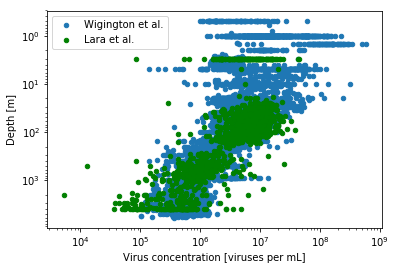

In [33]:
ax1 = clean_wig.plot.scatter(y='DEPTH',x='VIRUS',loglog=True)
clean_lara.plot.scatter(y='DEPTH',x='VIRUS',c='g',loglog=True,ax=ax1)
plt.legend(['Wigington et al.','Lara et al.'])
ax1.set_xlabel('Virus concentration [viruses per mL]')
ax1.set_ylabel('Depth [m]')
plt.gca().invert_yaxis()

Looking at these distributions, it seems as if in surface waters (up to 10 m), the concentration of viruses is quite constant, and then begins to drop with depth. To model this distribution, we fit a piecewise linear model, which uses a constant concentration in depths shallower than 10 meters, and a linear decrease in concenration below this depth:

In [102]:
def piecewise_linear(x, y1, y2,k1, k2):
    x0=1.
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:y1, lambda x:k2*x + y2])


def piecewise_fit(x,y):
    p , e = curve_fit(piecewise_linear, x, y)
    return p,e

def extraploate_piecewise(data):
    p,c = piecewise_fit(np.log10(data['DEPTH'].values),np.log10(data['VIRUS'].values))
    return (10**piecewise_linear(np.log10(np.linspace(1,4000,3999)), *p)*ml_to_m3).sum()*ocean_area

In [103]:
estimates.loc['Wigington','linear'] = extraploate_piecewise(clean_wig)
estimates.loc['Lara','linear'] = extraploate_piecewise(clean_lara)
estimates

/home/yinonbaron/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,bin - mean,bin - gmean,linear
Lara,2e+30,1e+30,1e+30
Wigington,2e+30,2e+30,1e+30


Our best estimate for the total number of viruses in the ocean is the geometric mean of all six different estimates:

In [59]:
best_virus_num = gmean(estimates.melt()['value'].values.astype(float))
print('Our best estimate for the total number of viruses in the ocean is %.1e viruses' % best_virus_num)

Our best estimate for the total number of viruses in the ocean is 1.5e+30 viruses


# Estimating the characteristic size of phages
In order to estimate the characteristic size of phages, we rely of data from quantitative transmission electron microscopy (qTEM) measurement of samples from 41 sites across the world's oceans, reported by [Brum et al.](http://dx.doi.org/10.1126/science.1261498). We extracted the data from figure 1 in Brum et al.:

In [60]:
# Load the data extracted from Brum et al.
data = pd.read_excel('phage_biomass_data.xlsx','Brum et al.',skiprows=1)
data.head()

,Site,5% diameter [nm],Median diameter [nm],95% diameter [nm]
0,18_SRF,4e+01,5e+01,7e+01
1,22_SRF,3e+01,5e+01,6e+01
2,23_DCM,5e+01,6e+01,7e+01
3,25_SRF,4e+01,5e+01,6e+01
4,25_DCM,4e+01,5e+01,7e+01


We use the geometric mean of the median diameters from each site as our best estimate for the characteristic diameter of phages:

In [61]:
phage_rad = gmean(data['Median diameter [nm]'])/2
print('Our best estimate for the radius of a phage is ≈%i nm.' %(phage_rad))

Our best estimate for the radius of a phage is ≈26 nm.


In [62]:
r = (data['95% diameter [nm]']-data['Median diameter [nm]']).mean()

## Estimating the carbon content of phages
To estimate the carbon content of phages, we rely on a biophysical model described in [Jover et al.](http://dx.doi.org/10.1038/nrmicro3289), which describes the carbon content of a phage as a function of its radius. The relation between the radius of phages and their total number of carbon atoms described in Jover et al. is: 
$$ C_{head} = \frac{4\pi(r_c-h)^3C_{bp}fill}{3v_{bp}} + \frac{4\pi d_C(3r_c^2h-3h^2r_c+h^3)}{3}$$
Where $C_{head}$ is the total number of carbon atoms, $r_c$ is the radius of the phage, h is the thickness of the phage capsid, $C_{bp}$ is the number of carbon atoms in a single base pair of DNA, *fill* is that fraction of the phage volume that is filled with DNA, $v_{bp}$ is the volume of a single base pair of DNA, and $d_C$ is the number of carbon atoms per volume of protein.

To get from the total number of carbon atoms to an estimate of the carbon content of a single phage, we can multiply the total number of atoms by the molecular weight of carbon, and divide by Avogadro's number.

Jover et al. supply estimates for each of the parameters in the model, as well as their respective uncertainties. We plug into this model our estimates for the radius of phages in order to get an estimate for the carbon content of phages, as well as the uncertainty associated with this esitmate. We use 1.96 times the uncertainty reported in Jover et al. to calculate 95% confidence interval for the carbon content estimate.

In [185]:
# Import uncertainties library to deal with the error propagation
from uncertainties import ufloat

##############################
# Define the model parameters#
##############################

# The phage radius we calculated in the phage size section [nm]
r_c = phage_rad

# The thickness of the phage capsid [nm]
h = ufloat(2.5,0.3*1.96)

# The number of caron atoms in a single DNA base pair
C_bp = ufloat(19.5,0.1*1.96)

# The fraction of the phage capsid filled with DNA
fill = ufloat(0.53,0.04*1.96)

# The volume of a single base pair [nm^3]
v_bp = ufloat(0.34*np.pi,0)

# The number of carbon atoms per volume of proteins [# nm^-3]
d_C = ufloat(31,1*1.96)

#Avogadro's number [molecules per mol]
Na = 6e23 

# Molecular weight of carbon [g per mol]
M_C = 12

# Define the eqation for deriving the carbon content of a phage as a function of it's radius
func = lambda x: ((4*np.pi*(x-h)**3*C_bp*fill)/(3*v_bp) + 4*np.pi*d_C*(3*x**2*h-3*h**2*x+h**3)/3)*M_C/Na

#C_head = (4*np.pi*(r_c-h)**3*C_bp*fill)/(3*v_bp) + 4*np.pi*d_C*(3*r_c**2*h-3*h**2*r_c+h**3)/3

# Calculate our best estimate for the carbon content of a single phage
best_cc = func(r_c)

print('Our best estimate for the carbon content of a single phage is ≈{:10.1e} g'.format(best_cc))

Our best estimate for the carbon content of a single phage is ≈   2.3e-17+/-   0.3e-17 g


# Estimating the biomass of phages
Our estimate of the total biomass of phages relies upon the estimates for the total number of phages and the carbon content of a single phage which we derived in the relevant sections:

In [75]:
best_cc*best_virus_num/1e15

0.034285894453577444+/-0.0037479693660278333

In [77]:
best_estimate = best_virus_num*best_cc
print('Our best estimate for the total biomass of marine phages is ≈%.2f Gt C' %(best_estimate.nominal_value/1e15))

Our best estimate for the total biomass of marine phages is ≈0.03 Gt C


# Uncertainty analysis
To assess the uncertainty associated with the estimate of the global biomass of marine viruses, we project the uncertainty associated with our estimate of the total number of viruses and the uncertainty associated with our estimate of the carbon content of marine viruses.

## Number of viruses
To project the uncertainty associated with our estimate of the total number of viruses, we rely on the variance between the six estimates we generated for the total number of marine viruses. Since our estimates are not completely independent of each other, we rely on the multiplicative standard deviation of the estimates, instead of their multiplicative standard error, as the base of our projection of the uncertainty associated with our estimate of the total number of marine viruses.

In [182]:
num_CI = 10**(pd.np.log10(estimates.melt()['value'].values.astype(float)).std()*1.96)
print('Our projection for the uncertainty associated with our estimate for the total number of marine viruses is %.1f-fold' % num_CI)

Our projection for the uncertainty associated with our estimate for the total number of marine viruses is 1.5-fold


## Carbon content
To assess the uncertainty associated with the estimate of the radius of a single phage, we use the variability of capsid radii in the sites reported in Brum et al. We calculate the relative multiplicative uncertainty of the variation within a site and between sites. We take the higher uncertainty of the two as our best estimate for the uncertainty associated with the radius of phages.

In [183]:
intra_CI = 1+gmean((data['95% diameter [nm]'] - data['5% diameter [nm]'])/data['Median diameter [nm]']/2)
inter_CI = geo_CI_calc(data['Median diameter [nm]'])

print('The intra site uncertainty in the radius of phages is ≈%0.1f-fold' %intra_CI)
print('The intra sample uncertainty in the radius of phages is ≈%0.2f-fold' %inter_CI)

rad_CI = np.max([intra_CI,inter_CI])

The intra site uncertainty in the radius of phages is ≈1.4-fold
The intra sample uncertainty in the radius of phages is ≈1.02-fold


In each site Brum et al. sampled ≈100 phages, so the intra-site uncertainty should be much lower. Nevertheless, the uncertainty we calculated doesn’t take into consideration the fact that viruses from other environments might have different size ranges. Even though phages isolated from deep terrestrial deep subsurface seem to be in the same size range range ([Eydal et al.](http://dx.doi.org/10.1038/ismej.2009.66)), we chose to use the 95% variability within each site as a measure of the uncertainty in the radius of a single pahge, to take into account possible variability of phage sizes in other environments.

To propagate the uncertainty in the radius of a single phage into the uncertainty in the carbon content of a single phage, we use a numerical approach. We chose to use this approach as propagating the uncertainty in the radius of phages creates a probability distribution of the carbon content of a single phage which is not gaussian, and thus the uncertainty ranges a normal error propagation procedure will output will be non-informative. Namely, the additive standard error that we will get will be higher than the nominal estimate, but in reality there is no phage with a netagive radius length.
Therefore, in order to quanitfy the uncertainty of the carbon content of a single phage stemming from the uncertainty in our estimate for the radius of a single phage, we sample 1000 times from a log-normal distribution of radii with a mean that is equal to our best estimate for the radius of a phage, and a multiplicative standard diviation which is equal to the uncertainty for the radius of a phage we project. We feed these sampled radii into our model and calculate a carbon content for each radius, resulting in a distribution of carbon content estimates. We take the multiplicative ratio between the 2.5% and 97.5% percentiles and our best estimate for the carbon content as our best estimate for the uncertainty of the carbon content of a single phage stemming from the uncertainty in our estimate for the radius of a single phage.

In [190]:
# Sample 1000 from a log-normal distribution of radii
rad_dist = np.random.lognormal(np.log(phage_rad),np.log(rad_CI)/1.96,1000)

# Calculate the carbon content for each radius
cc_dist = func(rad_dist)

# Calculate the upper and lower multiplicative ratios of the carbon content
upper_CI = np.percentile([x.nominal_value for x in cc_dist],97.5)/best_cc
lower_CI = best_cc/np.percentile([x.nominal_value for x in cc_dist],2.5)

rad_cc_CI = np.mean([upper_CI,lower_CI]).nominal_value

print('Our best estimate for the uncertainty of the carbon content of a single phage stemming from the uncertainty in our estimate for the radius of a single phage is ≈%.1f-fold' %rad_cc_CI)

Our best estimate for the uncertainty of the carbon content of a single phage stemming from the uncertainty in our estimate for the radius of a single phage is ≈2.2-fold


The uncertainty associated with the parameters of the model is ≈1.2-fold:

In [191]:
model_param_CI =  1+best_cc.std_dev*1.96/best_cc.nominal_value
print('The uncertainty associated with the parameters of the model is %.1f-fold' %model_param_CI)

The uncertainty associated with the parameters of the model is 1.2-fold


We combine these two uncertainties as our best projection for the uncertainty associated with the carbon content of a single phage:

In [192]:
cc_CI = CI_prod_prop(np.array([rad_cc_CI,model_param_CI]))
print('Our best projection for the uncertainty associated with the carbon content of a single phage is ≈%.1f-fold' %cc_CI)

Our best projection for the uncertainty associated with the carbon content of a single phage is ≈2.3-fold


We propagate the uncertainty associated with the carbon content of viruses with the uncertainty associated with the total number of viruses to project the uncertainty associated with the total biomass of marine viruses:

In [194]:
biomass_CI = CI_prod_prop(np.array([cc_CI,num_CI]))
print('Our best projection of the uncertainty associated with our estimate for the total biomass of marine viruses is %.1f-fold' %biomass_CI)

Our best projection of the uncertainty associated with our estimate for the total biomass of marine viruses is 2.5-fold


In order to estimate the total biomass of phages, we multiply our estimate of the total number of phages by our estimate of the carbon content of a single phage.

In [197]:
update_results(sheet='Data', 
               row='Viruses', 
               col=['Biomass', 'Uncertainty'],
               values=[best_estimate.nominal_value/1e15,biomass_CI],
               path='../data_20190829.xlsx')